<a href="https://colab.research.google.com/github/Lucazere00/music_emotion_recognition/blob/main/music_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Music Emotion Recognition (MER)**

**Analisi e Classificazione delle emozioni nei Brani Musicali tramite Deep Learning**

# **Configurazione dell'ambiente e Dataset**

In [ ]:
!pip install librosa --upgrade
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow
!git clone https://github.com/Lucazere00/music_emotion_recognition.git

Cloning into 'music_emotion_recognition'...
remote: Enumerating objects: 7291, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 7291 (delta 14), reused 7 (delta 1), pack-reused 7260 (from 2)
Receiving objects: 100% (7291/7291), 1.96 GiB | 34.72 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [ ]:
import seaborn as sns
import pandas as pd
from datetime import datetime
import os
import numpy as np
from google.colab import drive
import librosa
import librosa.display
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import librosa
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import kagglehub

In [ ]:
path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")

print("Path to dataset files:", path)

100%|██████████| 1.83G/1.83G [00:14<00:00, 140MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1


In [ ]:
dataset_path = path
print(os.listdir(dataset_path))

audio_dir = os.path.join(dataset_path, 'DEAM_audio', 'MEMD_audio')
annotations_dir = os.path.join(dataset_path, 'DEAM_Annotations', 'annotations','annotations averaged per song', 'song_level','static_annotations_averaged_songs_1_2000.csv')

# verifico i paths
print("Audio Directory Path:", audio_dir)
print("Static CSV Path:", annotations_dir)

# verifico se i paths esistono
if os.path.exists(audio_dir):
    print("Audio directory exists.")
else:
    print("Audio directory does not exist!")

if os.path.exists(annotations_dir):
    print("Static CSV file exists.")
else:
    print("Static CSV file does not exist!")

['features', 'DEAM_Annotations', 'DEAM_audio']
Audio Directory Path: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_audio/MEMD_audio
Static CSV Path: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv
Audio directory exists.
Static CSV file exists.


È stato utilizzato il dataset DEAM-mediaeval (Emotional Analysis in Music), uno standard che include annotazioni su Valence (positività/negatività) e Arousal (intensità energetica).

# **Exploratory data analysis (EDA)**

In [ ]:
# genero il dataframe pandas
annotations_df = pd.read_csv(annotations_dir)

# le prime istanze
print("Dataset Preview:")
print(annotations_df.head())

# informazioni
print("\nDataset Info:")
print(annotations_df.info())

# statistiche
print("\nSummary Statistics:")
print(annotations_df.describe())

Dataset Preview:
   song_id   valence_mean   valence_std   arousal_mean   arousal_std
0        2            3.1          0.94            3.0          0.63
1        3            3.5          1.75            3.3          1.62
2        4            5.7          1.42            5.5          1.63
3        5            4.4          2.01            5.3          1.85
4        7            5.8          1.47            6.4          1.69

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1    valence_mean  1744 non-null   float64
 2    valence_std   1744 non-null   float64
 3    arousal_mean  1744 non-null   float64
 4    arousal_std   1744 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 68.3 KB
None

Summary Statistics:
           song_id   valence_mean   valence_std   arousal_mean 

In [ ]:
# verifico se ci sono valori nulli
print(annotations_df.isna().sum())

song_id          0
 valence_mean    0
 valence_std     0
 arousal_mean    0
 arousal_std     0
dtype: int64


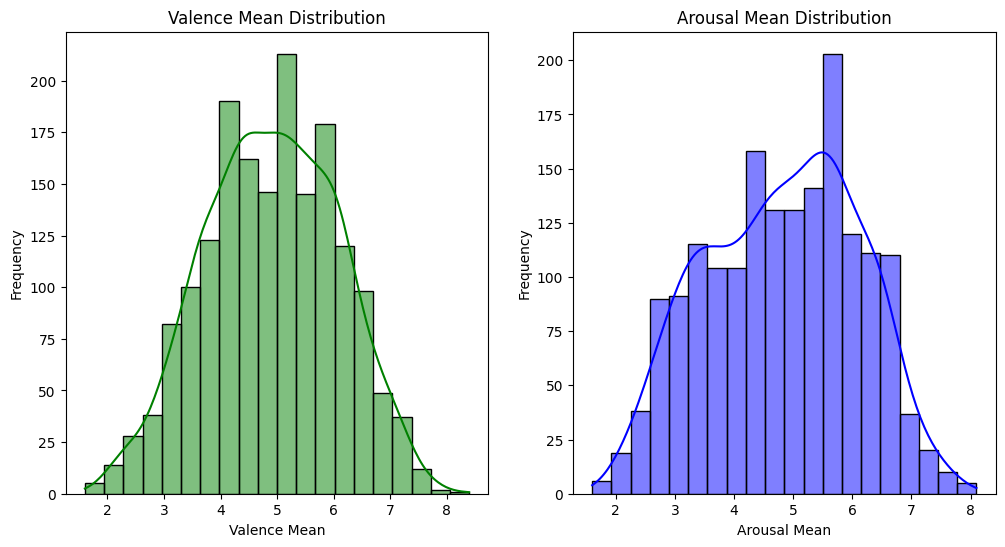

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 6))
annotations_df.columns = annotations_df.columns.str.strip()

# distribuzione valence_mean
plt.subplot(1, 2, 1)
sns.histplot(annotations_df['valence_mean'], kde=True, color='green', bins=20)
plt.title('Valence Mean Distribution')
plt.xlabel('Valence Mean')
plt.ylabel('Frequency')

# distribuzione arousal_mean
plt.subplot(1, 2, 2)
sns.histplot(annotations_df['arousal_mean'], kde=True, color='blue', bins=20)
plt.title('Arousal Mean Distribution')
plt.xlabel('Arousal Mean')
plt.ylabel('Frequency')
plt.savefig('/content/music_emotion_recognition/histograms.png')
plt.show()
plt.tight_layout()
plt.show()

Mi sono concentrato sul file static_annotations_averaged_songs_1_2000.csv, che fornisce una media dei valori emozionali per ogni brano.
Attraverso gli istogrammi ho analizzato la distribuzione di Valence e Arousal, osservando che la maggior parte dei brani si attesta su valori medi (intorno a 5 in una scala 1-9).

# **Definizione delle categorie emozionali**

In [ ]:
v_low, v_high = annotations_df['valence_mean'].quantile([0.33, 0.66])
a_low, a_high = annotations_df['arousal_mean'].quantile([0.33, 0.66])

def classes(row):
    v, a = row['valence_mean'], row['arousal_mean']

    if v >= v_high and a >= a_high:
        return 'Happy'
    elif v <= v_low and a >= a_high:
        return 'Angry'
    elif v <= v_low and a <= a_low:
        return 'Sad'
    elif v >= v_high and a <= a_low:
        return 'Relaxed'
    else:
        return 'Neutral'

annotations_df['label'] = annotations_df.apply(classes, axis=1)
print(annotations_df[['song_id', 'valence_mean', 'arousal_mean', 'label']].head(20))
print(annotations_df['label'].value_counts())

    song_id  valence_mean  arousal_mean    label
0         2           3.1           3.0      Sad
1         3           3.5           3.3      Sad
2         4           5.7           5.5    Happy
3         5           4.4           5.3  Neutral
4         7           5.8           6.4    Happy
5         8           3.2           4.8  Neutral
6        10           4.0           4.7  Neutral
7        12           5.5           5.8    Happy
8        13           3.2           4.0      Sad
9        17           4.4           6.0  Neutral
10       18           4.8           3.9  Neutral
11       19           5.9           4.3  Neutral
12       20           5.4           6.5  Neutral
13       21           6.6           6.3    Happy
14       22           4.0           4.8  Neutral
15       24           5.3           3.9  Neutral
16       25           7.9           4.7  Neutral
17       31           4.7           3.8  Neutral
18       32           4.2           3.3      Sad
19       35         

In [ ]:
annotations_df = annotations_df[annotations_df['label'] != 'Neutral']
print(annotations_df['label'].value_counts())

label
Happy      385
Sad        367
Angry       59
Relaxed     52
Name: count, dtype: int64


Ho trasformato il problema in una classificazione multi-classe dividendo lo spazio Valence-Arousal in 4 quadranti:
- Alta Valence/ Alta Arousal = Happy;
- Bassa Valence/ Bassa Arousal = Sad;
- Bassa Valence/ Alta Arousal = Angry;
- Alta Valence/ Bassa Arousal = Relaxed;

È stata utilizzata la soglia di 5.0 per distinguere tra "Alto" e "Basso", bilanciando così le etichette in base al centro della scala 1-9.
Tutte le etichette centrali chiamate 'Neutral' sono state eliminate in quanto confondono molto durante l'apprendimento.

# **Estrazione del Mel-Spectrogram**

**Convertiamo ogni file audio in rappresentazioni visive (utili per le CNN)**

In [ ]:
def extract_mel_segment(file_path, start_sec, duration=5, n_mels=128, max_len=256):
    # Carichiamo solo il segmento che ci interessa (offset e duration)
    y, sr = librosa.load(file_path, sr=22050, offset=start_sec, duration=duration)

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalizzazione tra 0 e 1 (aiuta molto la CNN a convergere)
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)

    # Padding/Cropping per assicurare che la larghezza sia max_len
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]

    return mel_db

In [ ]:
from tqdm import tqdm

X = []
y = []

# 5 segmenti da 5 secondi per TUTTI
segments = [(i * 6, 5) for i in range(5)]

for _, row in tqdm(annotations_df.iterrows(),
                   total=len(annotations_df),
                   desc="Estrazione Spettrogrammi"):

    file_path = os.path.join(audio_dir, f"{int(row['song_id'])}.mp3")
    label = row['label']

    if not os.path.exists(file_path):
        continue

    for start, dur in segments:
        try:
            mel_spec = extract_mel_segment(
                file_path,
                start_sec=start,
                duration=dur,
                max_len=256
            )
            X.append(mel_spec)
            y.append(label)

        except Exception:
            continue

Estrazione Spettrogrammi: 100%|██████████| 863/863 [02:19<00:00,  6.19it/s]


# **Preprocessing e codifica**

**Prepariamo i dati per il training**

In [ ]:
X = np.array(X)[..., np.newaxis]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print("Classi mappate:", label_encoder.classes_)
print("Forma X:", X.shape)

Classi mappate: ['Angry' 'Happy' 'Relaxed' 'Sad']
Forma X: (4315, 128, 256, 1)


In [ ]:
from collections import Counter
print(Counter(y))

Counter({'Happy': 1925, 'Sad': 1835, 'Angry': 295, 'Relaxed': 260})


In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(3.656779661016949), 1: np.float64(0.5603896103896104), 2: np.float64(4.149038461538462), 3: np.float64(0.587874659400545)}


In [ ]:
groups = annotations_df['song_id'].values.repeat(5)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y_categorical, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_categorical[train_idx], y_categorical[test_idx]

# **Definizione della rete neurale CNN**

In [ ]:
model = Sequential([
    # Cambiato input_shape a 256 di larghezza
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 256, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Aggiungiamo un terzo blocco per gestire la complessità dell'audio
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), # Aumentato leggermente per gestire il rumore delle label
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 125, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 125, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,881,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,975,492 (26.61 MB)

 Trainable params: 6,975,044 (26.61 MB)

 Non-trainable params: 448 (1.75 KB)

Struttura a 3 blocchi convoluzionali con Batch Normalization per velocizzare la convergenza e stabilizzare l'apprendimento.

Uso del Dropout (0.5) nel layer denso per prevenire l'overfitting, data la complessità e il rumore intrinseco nelle annotazioni emozionali.

Ho calcolato i pesi delle classi (compute_class_weight) per compensare gli sbilanciamenti nel dataset.

Ho configurato Adam con un learning rate basso (0.0001) per garantire un apprendimento più stabile e fine-tuned.

Utilizzo della categorical_crossentropy, standard per problemi di classificazione multi-classe.

# **Addestramento del modello**

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),class_weight=class_weights)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.4044 - loss: 2.4776 - val_accuracy: 0.0867 - val_loss: 10.5513
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step - accuracy: 0.5750 - loss: 1.3034 - val_accuracy: 0.0867 - val_loss: 14.4040
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - accuracy: 0.5717 - loss: 1.2326 - val_accuracy: 0.1006 - val_loss: 10.6683
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.5507 - loss: 1.1828 - val_accuracy: 0.3965 - val_loss: 4.4994
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - accuracy: 0.6137 - loss: 1.1486 - val_accuracy: 0.4636 - val_loss: 2.1631
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.6860 - loss: 0.9483 - val_accuracy: 0.5075 - val_loss: 1.0895
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - accuracy: 0.6698 - loss: 0.9414 - val_accuracy: 0.6867 - val_loss: 0.9346
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.6799 - loss: 0.9385 - val_a

KeyboardInterrupt: 

# **Salvataggio del modello**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/music_emotion_recognition_model_2.keras'
model.save(model_path)

print(f"Modello salvato con successo in: {model_path}")

Mounted at /content/drive
Modello salvato con successo in: /content/drive/MyDrive/music_emotion_recognition_model_2.keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model = load_model('/content/drive/MyDrive/music_emotion_recognition_model_2.keras')

Mounted at /content/drive


# **Valutazione sul test set**

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy sul test set: {accuracy:.2f}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7486 - loss: 0.7862
Accuracy sul test set: 0.74


In [ ]:
from sklearn.metrics import classification_report

# Get predictions from the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Define labels from the label_encoder
labels = label_encoder.classes_

# Get the classification report
report = classification_report(y_true, y_pred, target_names=labels)

print(report)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

       Angry       0.18      0.11      0.13        75
       Happy       0.83      0.79      0.81       335
     Relaxed       0.19      0.38      0.25        50
         Sad       0.86      0.85      0.86       405

    accuracy                           0.74       865
   macro avg       0.51      0.53      0.51       865
weighted avg       0.75      0.74      0.74       865



# **Confusion matrix**

**Ha come scopo quello di visualizzare quali classi il modello confonde tra loro**

In [ ]:
# Otteniamo le predizioni del modello
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcolo e visualizzazione della confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predetto")
plt.ylabel("Vero")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# **Test sulla canzone 'Happy' di Pharrell Williams**

In [ ]:
!pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.4 MB/s eta 0:00:00


In [ ]:
# 1. DOWNLOAD DA YOUTUBE
def download_youtube_audio(url, output_name='test_audio.mp3'):
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
        'outtmpl': 'test_audio', # Salva come test_audio.mp3
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    return 'test_audio.mp3'

# 2. ESECUZIONE TEST
youtube_url = 'https://www.youtube.com/watch?v=ZbZSe6N_BXs' # Happy - Pharrell
audio_file = download_youtube_audio(youtube_url)

def predict_external_song(file_path, model):
    # Caricamento 5 sec
    y, sr = librosa.load(file_path, offset=20.0, duration=5.0)

    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Resize a 128x256 (come il tuo training)
    if mel_spec_db.shape[1] < 256:
        mel_spec_db = np.pad(mel_spec_db, ((0,0), (0, 256 - mel_spec_db.shape[1])))
    else:
        mel_spec_db = mel_spec_db[:, :256]

    img = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    img = np.expand_dims(img, axis=(0, -1)) # Shape (1, 128, 256, 1)

    # Predizione
    preds = model.predict(img)
    class_idx = np.argmax(preds)


    labels = ['Angry', 'Happy', 'Relaxed', 'Sad']
    emotion = labels[class_idx]

    print(f"Risultato per '{file_path}': {emotion} (Confidenza: {preds[0][class_idx]*100:.2f} %)")

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr,cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"CNN Test: Haapy-Pharrel Williams - Predizione: {emotion}")
    plt.savefig('/content/music_emotion_recognition/Happy_Pharrell_Williams.png')
    plt.show()

    return mel_spec_db, emotion

spec, emo = predict_external_song(audio_file, model)

[youtube] Extracting URL: https://www.youtube.com/watch?v=ZbZSe6N_BXs
[youtube] ZbZSe6N_BXs: Downloading webpage


[youtube] ZbZSe6N_BXs: Downloading android sdkless player API JSON
[youtube] ZbZSe6N_BXs: Downloading web safari player API JSON


[youtube] ZbZSe6N_BXs: Downloading m3u8 information


[info] ZbZSe6N_BXs: Downloading 1 format(s): 251
[download] Destination: test_audio
[download] 100% of    3.64MiB in 00:00:00 at 22.33MiB/s  
[ExtractAudio] Destination: test_audio.mp3


KeyboardInterrupt: 

# **Test sulla canzone 'Someone like you' di Adele**

[youtube] Extracting URL: https://www.youtube.com/watch?v=hLQl3WQQoQ0
[youtube] hLQl3WQQoQ0: Downloading webpage


[youtube] hLQl3WQQoQ0: Downloading android sdkless player API JSON
[youtube] hLQl3WQQoQ0: Downloading web safari player API JSON


[youtube] hLQl3WQQoQ0: Downloading m3u8 information


[info] hLQl3WQQoQ0: Downloading 1 format(s): 251
[download] Destination: test_adele
[download] 100% of    4.88MiB in 00:00:00 at 32.07MiB/s  
[ExtractAudio] Destination: test_adele.mp3
Deleting original file test_adele (pass -k to keep)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Risultato per 'test_adele.mp3': Sad (Confidenza: 94.32%)


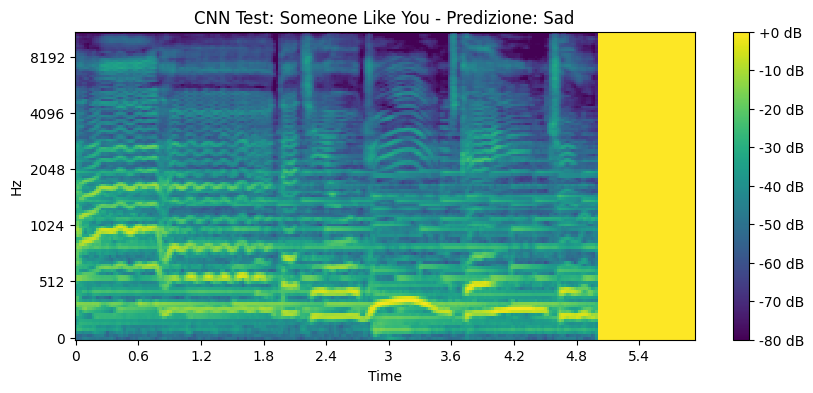

In [ ]:
# 1. DOWNLOAD DA YOUTUBE (Stessa funzione di prima)
def download_youtube_audio(url, output_name='test_adele'):
    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
        'outtmpl': output_name,
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    return output_name + '.mp3'

# 2. URL DI ADELE E DOWNLOAD
youtube_url_adele = 'https://www.youtube.com/watch?v=hLQl3WQQoQ0' # Someone Like You
audio_file_adele = download_youtube_audio(youtube_url_adele)

def predict_external_song(file_path, model):
    # Caricamento con OFFSET di 30 secondi per essere sicuri di prendere il mood corretto
    y, sr = librosa.load(file_path, offset=30.0, duration=5.0)

    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Resize a 128x256
    if mel_spec_db.shape[1] < 256:
        mel_spec_db = np.pad(mel_spec_db, ((0,0), (0, 256 - mel_spec_db.shape[1])))
    else:
        mel_spec_db = mel_spec_db[:, :256]


    img = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    img = np.expand_dims(img, axis=(0, -1)) # Shape (1, 128, 256, 1)

    # Predizione
    preds = model.predict(img)
    class_idx = np.argmax(preds)

    labels = ['Angry', 'Happy', 'Relaxed', 'Sad']
    emotion = labels[class_idx]

    print(f"Risultato per '{file_path}': {emotion} (Confidenza: {preds[0][class_idx]*100:.2f}%)")

    # Visualizzazione
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr,cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"CNN Test: Someone Like You - Predizione: {emotion}")
    plt.savefig('/content/music_emotion_recognition/someone_like_you.png')
    plt.show()

# Esecuzione
predict_external_song(audio_file_adele, model)

# **Test sulla canzone 'Thunderstruck' ACDC**

[youtube] Extracting URL: https://www.youtube.com/watch?v=v2AC41dglnM
[youtube] v2AC41dglnM: Downloading webpage


[youtube] v2AC41dglnM: Downloading android sdkless player API JSON
[youtube] v2AC41dglnM: Downloading web safari player API JSON


[youtube] v2AC41dglnM: Downloading m3u8 information


[info] v2AC41dglnM: Downloading 1 format(s): 251
[download] Destination: test_acdc
[download] 100% of    4.47MiB in 00:00:00 at 26.93MiB/s  
[ExtractAudio] Destination: test_acdc.mp3
Deleting original file test_acdc (pass -k to keep)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

--- RISULTATO FINALE ---
Canzone: test_acdc.mp3
Emozione Predetta: Relaxed
Confidenza: 32.87%
------------------------



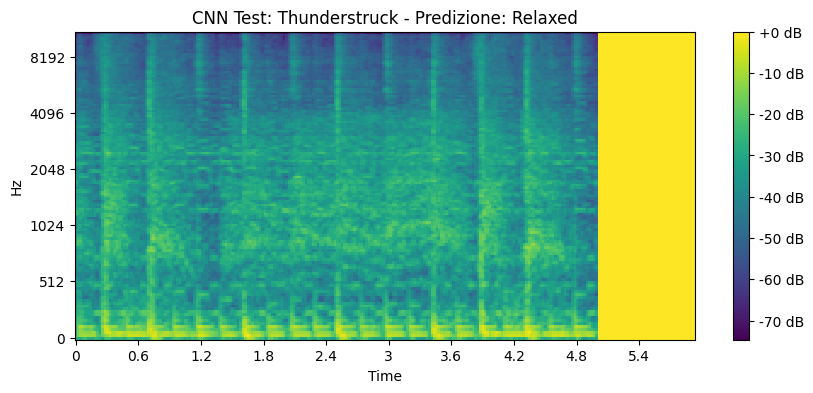

In [ ]:
# 1. FUNZIONE DOWNLOAD
def download_youtube_audio(url, output_name='test_acdc'):

    if os.path.exists(output_name + '.mp3'):
        os.remove(output_name + '.mp3')

    ydl_opts = {
        'format': 'bestaudio/best',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'mp3',
            'preferredquality': '192',
        }],
        'outtmpl': output_name,
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    return output_name + '.mp3'

# 2. FUNZIONE PREDIZIONE
def predict_external_song(file_path, model):
    # Caricamento audio
    y, sr = librosa.load(file_path, offset=40.0, duration=5.0)

    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Resize a 128x256
    if mel_spec_db.shape[1] < 256:
        mel_spec_db = np.pad(mel_spec_db, ((0,0), (0, 256 - mel_spec_db.shape[1])))
    else:
        mel_spec_db = mel_spec_db[:, :256]

    img = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    img = np.expand_dims(img, axis=(0, -1))

    # Predizione
    preds = model.predict(img)
    class_idx = np.argmax(preds)

    labels = ['Angry', 'Happy', 'Relaxed', 'Sad']
    emotion = labels[class_idx]

    print(f"\n--- RISULTATO FINALE ---")
    print(f"Canzone: {file_path}")
    print(f"Emozione Predetta: {emotion}")
    print(f"Confidenza: {preds[0][class_idx]*100:.2f}%")
    print(f"------------------------\n")

    # Plot
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"CNN Test: Thunderstruck - Predizione: {emotion}")


    save_path = '/content/music_emotion_recognition/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    plt.savefig(save_path + 'thunderstruck.png')
    plt.show()


youtube_url_acdc = 'https://www.youtube.com/watch?v=v2AC41dglnM'
audio_file_acdc = download_youtube_audio(youtube_url_acdc)
predict_external_song(audio_file_acdc, model)

# **Visualizzazione dei Mel-Spectrogram**

**Classe Happy**

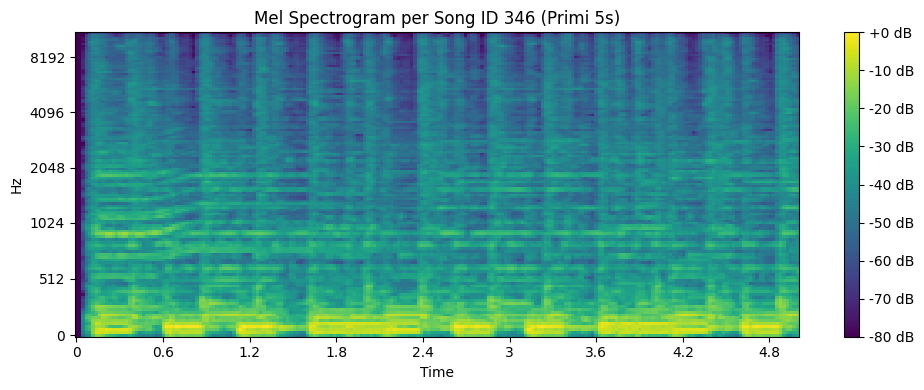

In [ ]:
sample_song_id_346 = 346

file_path_346 = os.path.join(audio_dir, f"{int(sample_song_id_346)}.mp3")
y_346, sr_346 = librosa.load(file_path_346, duration=5)

# Mel Spectrogram
mel_346 = librosa.feature.melspectrogram(y=y_346, sr=sr_346, n_mels=128)
mel_db_346 = librosa.power_to_db(mel_346, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_346, x_axis='time', y_axis='mel', sr=sr_346, vmin=-80, vmax=0, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram per Song ID {sample_song_id_346} (Primi 5s)')
plt.tight_layout()
plt.savefig('/content/music_emotion_recognition/Mel_Happy.png')
plt.show()

**Classe Sad**

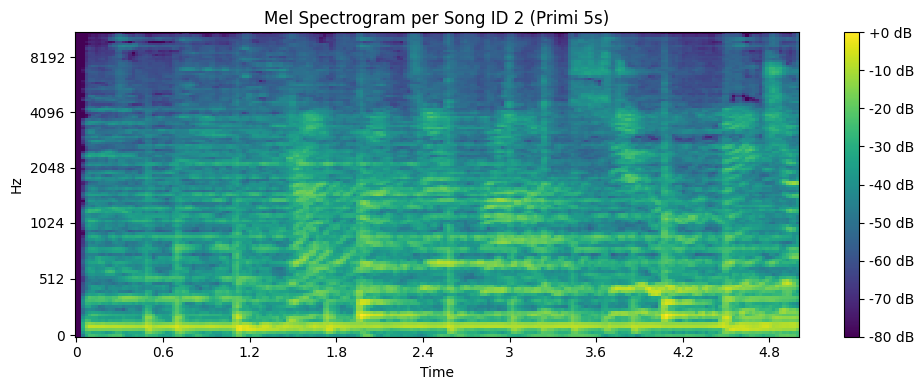

In [ ]:
sample_song_id_2 = 2

file_path_2 = os.path.join(audio_dir, f"{int(sample_song_id_2)}.mp3")
y_2, sr_2 = librosa.load(file_path_2, duration=5)

# Mel Spectrogram
mel_2 = librosa.feature.melspectrogram(y=y_2, sr=sr_2, n_mels=128)
mel_db_2 = librosa.power_to_db(mel_2, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_2, x_axis='time', y_axis='mel', sr=sr_2, vmin=-80, vmax=0, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram per Song ID {sample_song_id_2} (Primi 5s)')
plt.tight_layout()
plt.savefig('/content/music_emotion_recognition/Mel_Sad.png')
plt.show()

**Classe relaxed**

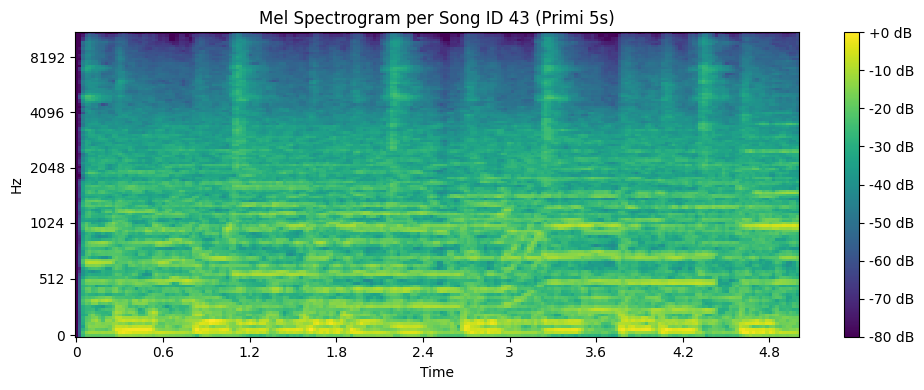

In [ ]:
sample_song_id_43 = 43

file_path_43 = os.path.join(audio_dir, f"{int(sample_song_id_43)}.mp3")
y_43, sr_43 = librosa.load(file_path_43, duration=5)

# Mel Spectrogram
mel_43 = librosa.feature.melspectrogram(y=y_43, sr=sr_43, n_mels=128)
mel_db_43 = librosa.power_to_db(mel_43, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_43, x_axis='time', y_axis='mel', sr=sr_43, vmin=-80, vmax=0, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel Spectrogram per Song ID {sample_song_id_43} (Primi 5s)')
plt.tight_layout()
plt.savefig('/content/music_emotion_recognition/Mel_Relaxed.png')
plt.show()

**Classe Angry**

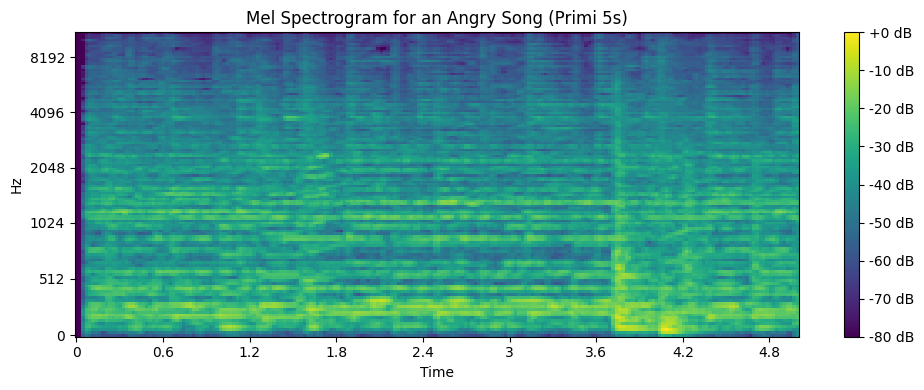

Mel-Spectrogram for the first Angry song displayed successfully.


<Figure size 640x480 with 0 Axes>

In [ ]:
sample_angry_song = annotations_df[annotations_df['label'] == 'Angry'].iloc[0]
sample_song_id_angry = int(sample_angry_song['song_id'])

file_path_angry = os.path.join(audio_dir, f"{sample_song_id_angry}.mp3")

y_angry, sr_angry = librosa.load(file_path_angry, duration=5)

# Mel Spectrogram
mel_angry = librosa.feature.melspectrogram(y=y_angry, sr=sr_angry, n_mels=128)
mel_db_angry = librosa.power_to_db(mel_angry, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_angry, x_axis='time', y_axis='mel', sr=sr_angry, vmin=-80, vmax=0, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram for an Angry Song (Primi 5s)')
plt.tight_layout()
plt.show()
plt.savefig('/content/music_emotion_recognition/Mel_Angry.png')
print("Mel-Spectrogram for the first Angry song displayed successfully.")

# **Confronto  visivo tra Mel-Spectrogram e MFCC**

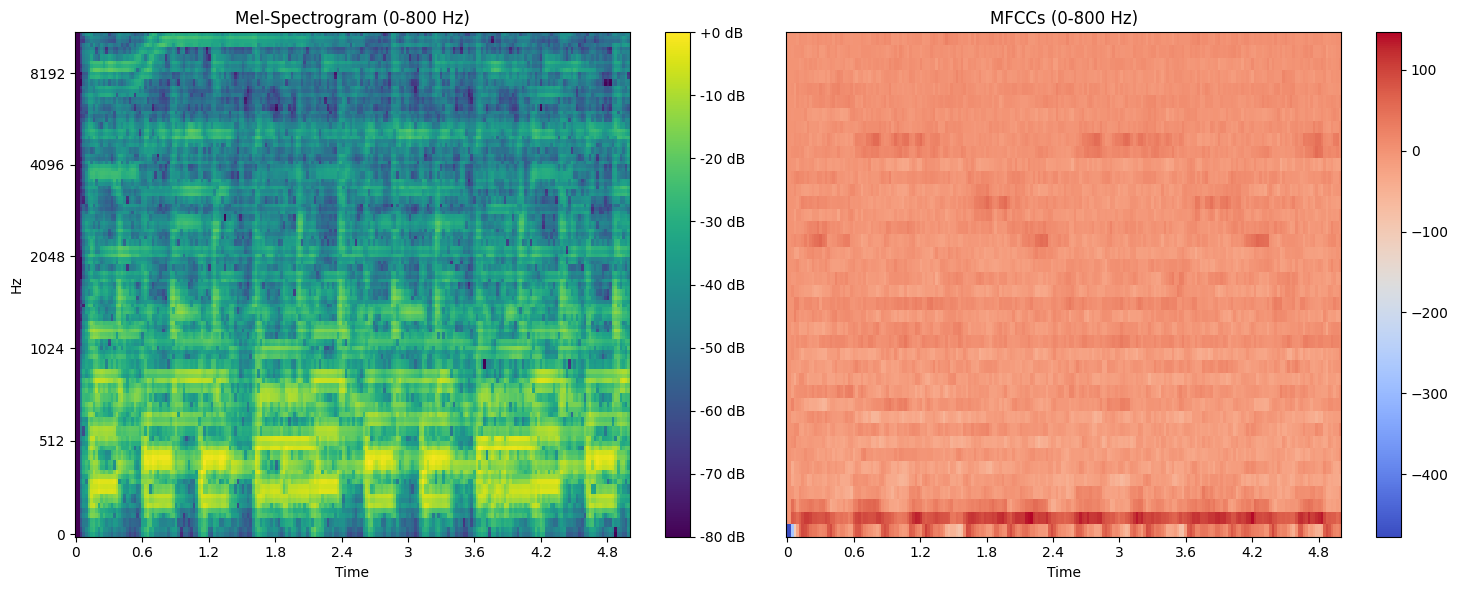

In [ ]:
file_path_mfcc_comparison = file_path_346
y_mfcc_comparison, sr_mfcc_comparison = librosa.load(file_path_mfcc_comparison, duration=5)

mel_mfcc_comparison = librosa.feature.melspectrogram(y=y_mfcc_comparison, sr=sr_mfcc_comparison, n_mels=128, fmax=800)

mel_db_mfcc_comparison = librosa.power_to_db(mel_mfcc_comparison, ref=np.max)

mfcc_features = librosa.feature.mfcc(y=y_mfcc_comparison, sr=sr_mfcc_comparison, n_mfcc=40, fmax=800)

plt.figure(figsize=(15, 6))


plt.subplot(1, 2, 1)
librosa.display.specshow(mel_db_mfcc_comparison, x_axis='time', y_axis='mel', sr=sr_mfcc_comparison, vmin=-80, vmax=0, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram (0-800 Hz)')


plt.subplot(1, 2, 2)
librosa.display.specshow(mfcc_features, x_axis='time', sr=sr_mfcc_comparison)
plt.colorbar()
plt.title('MFCCs (0-800 Hz)')

plt.tight_layout()
plt.savefig('/content/music_emotion_recognition/Mel_MFCC.png')
plt.show()

# **Transfer Learning**

**Utilizziamo modelli pre-addestrati su immagini (come VGG16) per analizzare spettrogrammi**


In [ ]:
X_rgb = np.repeat(X, 3, axis=-1)

# 2. PREPROCESSING SPECIFICO VGG16
# Applichiamo la normalizzazione che si aspetta la VGG
X_rgb_preprocessed = preprocess_input(X_rgb)

# 3. SPLIT DEI DATI (senza GroupShuffleSplit come hai scelto)
# Se hai già train_idx e test_idx dal codice precedente:
X_train_rgb = X_rgb_preprocessed[train_idx]
X_test_rgb = X_rgb_preprocessed[test_idx]
y_train = y_categorical[train_idx]
y_test = y_categorical[test_idx]

# --- ORA PUOI DEFINIRE IL MODELLO ---

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 256, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=predictions)

model_vgg.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# 4. TRAINING
history_vgg = model_vgg.fit(
    X_train_rgb, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_rgb, y_test),
    class_weight=class_weights # Changed from class_weights_dict to class_weights
)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 49s 303ms/step - accuracy: 0.3429 - loss: 1.3454 - val_accuracy: 0.3873 - val_loss: 1.6147
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.4247 - loss: 1.3369 - val_accuracy: 0.3873 - val_loss: 1.4830
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.4823 - loss: 1.2861 - val_accuracy: 0.3873 - val_loss: 1.4003
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.5273 - loss: 1.3624 - val_accuracy: 0.5121 - val_loss: 1.3177
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.5501 - loss: 1.2671 - val_accuracy: 0.5988 - val_loss: 1.2255
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5563 - loss: 1.2413 - val_accuracy: 0.5792 - val_loss: 1.1722
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.5716 - loss: 1.2167 - val_accuracy: 0.5803 - val_loss: 1.1372
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.5583 - loss: 1

In [ ]:
loss, accuracy = model_vgg.evaluate(X_test_rgb, y_test)
print(f'Accuracy sul test set: {accuracy:.2f}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.6013 - loss: 1.0523
Accuracy sul test set: 0.61


In [ ]:
from sklearn.metrics import classification_report

# Get predictions from the VGG model
y_pred_probs_vgg = model_vgg.predict(X_test_rgb)
y_pred_vgg = np.argmax(y_pred_probs_vgg, axis=1)
y_true_vgg = np.argmax(y_test, axis=1) # y_test is already for VGG context

# Get labels (assuming label_encoder is still available)
labels_vgg = label_encoder.classes_

# Get the classification report for the VGG model
report_vgg = classification_report(y_true_vgg, y_pred_vgg, target_names=labels_vgg)

print("Classification Report for Transfer Learning (VGG16) Model:\n")
print(report_vgg)

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step
Classification Report for Transfer Learning (VGG16) Model:

              precision    recall  f1-score   support

       Angry       0.08      0.07      0.07        75
       Happy       0.73      0.65      0.69       335
     Relaxed       0.11      0.36      0.17        50
         Sad       0.82      0.71      0.76       405

    accuracy                           0.61       865
   macro avg       0.44      0.45      0.42       865
weighted avg       0.68      0.61      0.64       865



# **Confusion matrix**

28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step


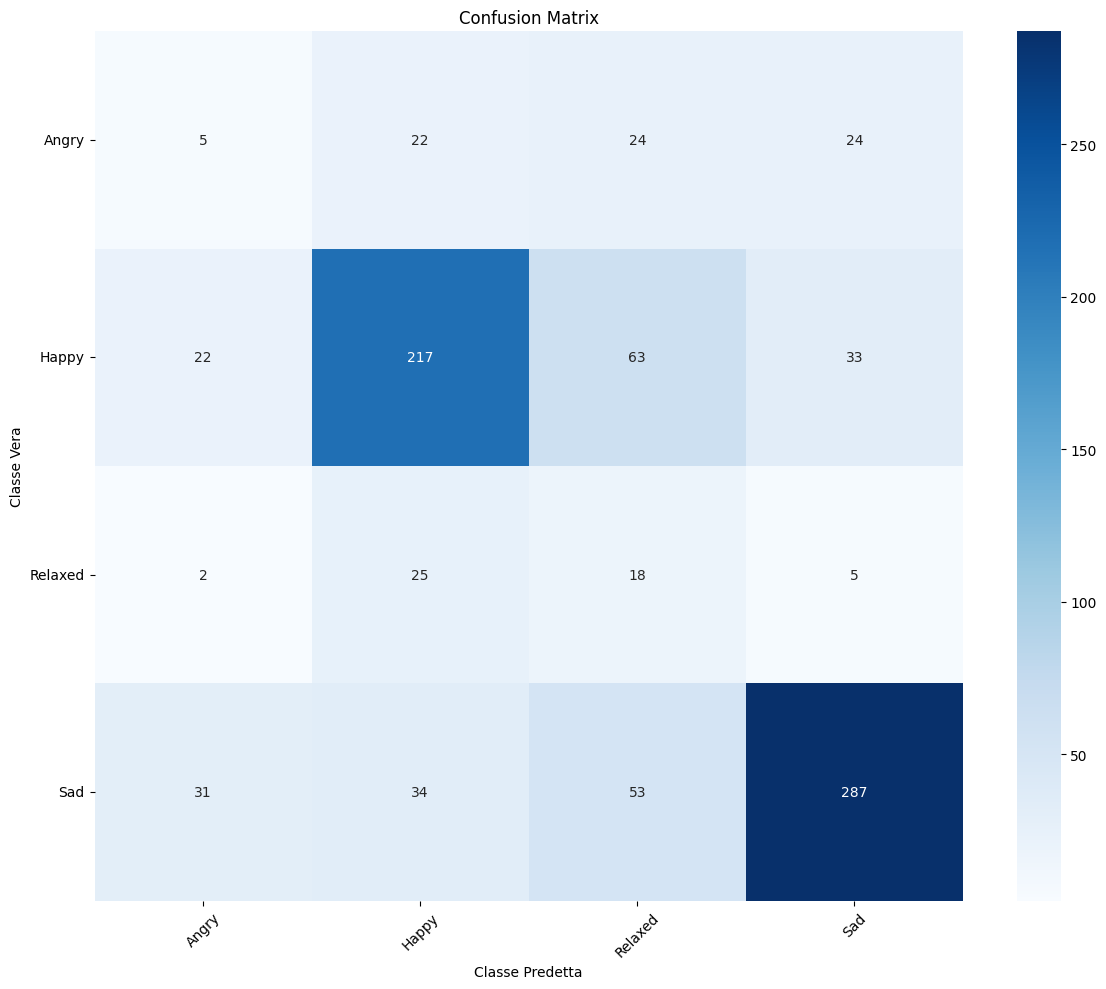

In [ ]:
# Predizioni sul test set
y_pred_probs = model_vgg.predict(X_test_rgb)  # Use model_vgg and X_test_rgb
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Classe Predetta")
plt.ylabel("Classe Vera")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

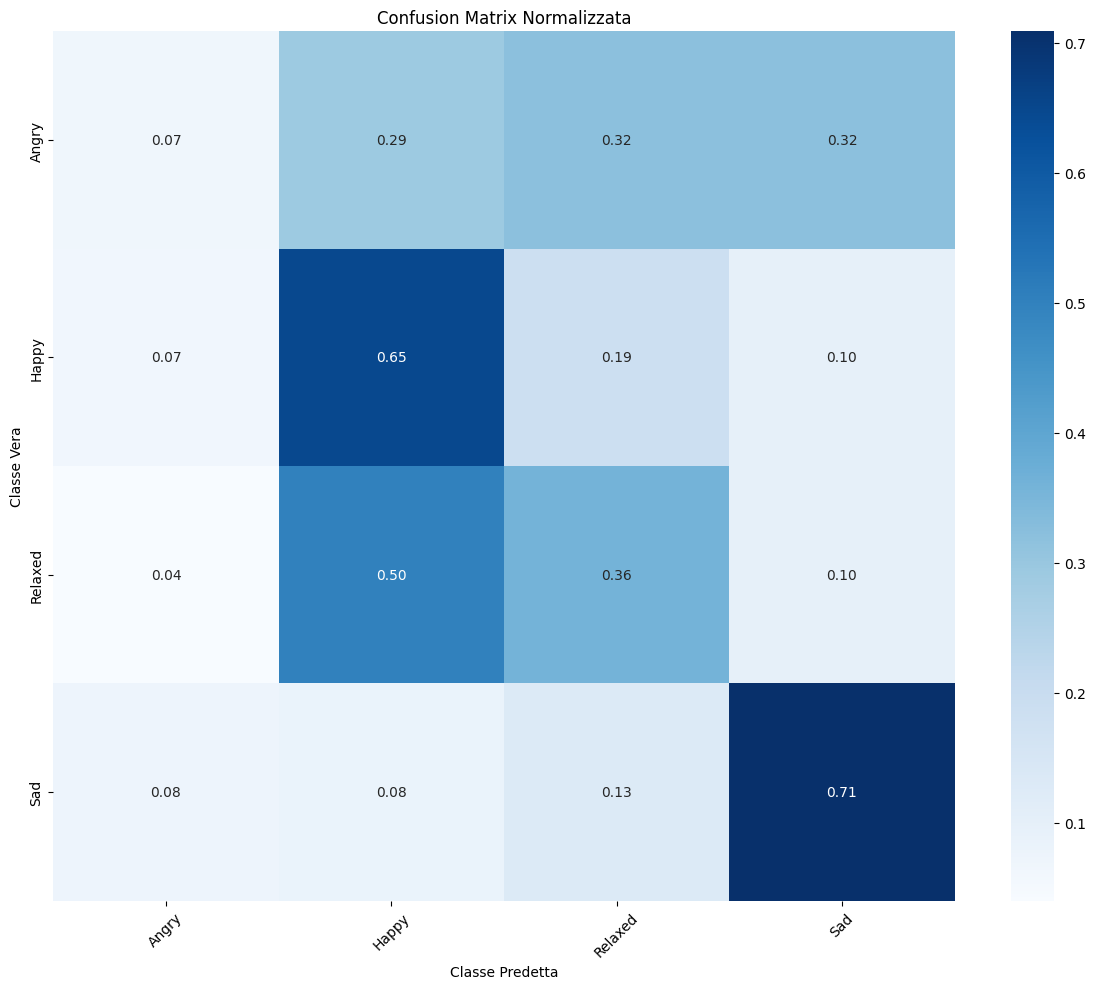

In [ ]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Classe Predetta")
plt.ylabel("Classe Vera")
plt.title("Confusion Matrix Normalizzata")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Visualizzazione e ascolto dei dati**

**Serve a integrare nel notebook sia la visualizzazione dello spettrogramma sia l’ascolto del frammento audio corrispondente al mel-spectrogram generato**

In [ ]:
#Funzione per mostrare spettrogramma + player audio
def show_and_play(file_path):
    # Carica segnale e rate, limitando a 5 secondi
    y, sr = librosa.load(file_path, sr=None, duration=5)

    # Mostra waveform
    plt.figure(figsize=(12, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")
    plt.tight_layout()
    plt.show()

    # Mostra mel-spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel-Spectrogram")
    plt.tight_layout()
    plt.show()

    # Player audio interattivo
    display(Audio(data=y, rate=sr))

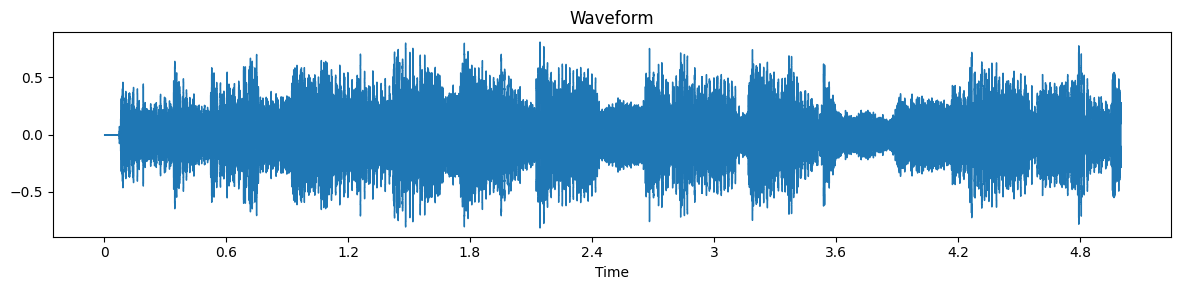

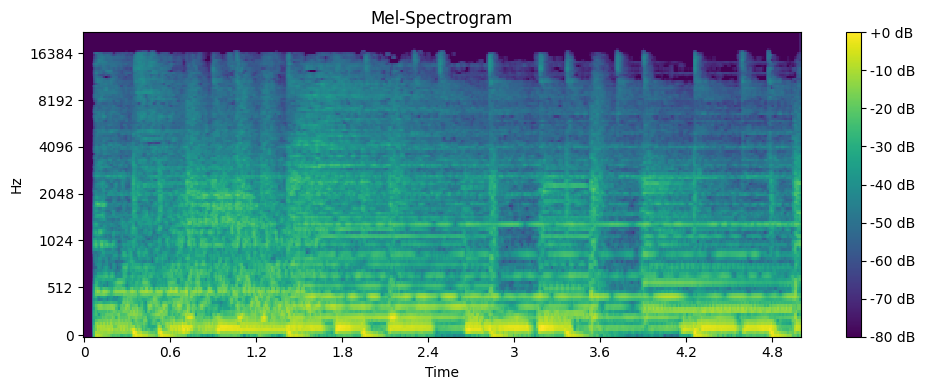

In [ ]:
sample_song_id = annotations_df[annotations_df['label'] == 'Happy'].iloc[0]['song_id']
file = os.path.join(audio_dir, f"{int(sample_song_id)}.mp3")
show_and_play(file)

# **Analisi degli errori**

**Serve per capire dove e perché il modello sbaglia, e per migliorarlo**

In [ ]:
# Predizione
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 601ms/step


In [ ]:
confused = pd.DataFrame({'true': y_true, 'pred': y_pred})
confused['true_label'] = label_encoder.inverse_transform(confused['true'])
confused['pred_label'] = label_encoder.inverse_transform(confused['pred'])

print(confused[confused['true'] != confused['pred']].groupby(['true_label', 'pred_label']).size())

true_label  pred_label
Angry       Happy         24
            Relaxed       17
            Sad           26
Happy       Angry         12
            Relaxed       37
            Sad           20
Relaxed     Angry          4
            Happy         18
            Sad            9
Sad         Angry         21
            Happy         12
            Relaxed       28
dtype: int64


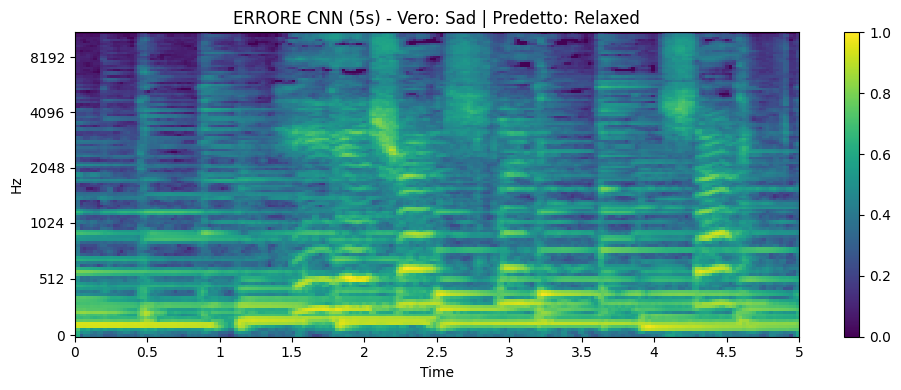

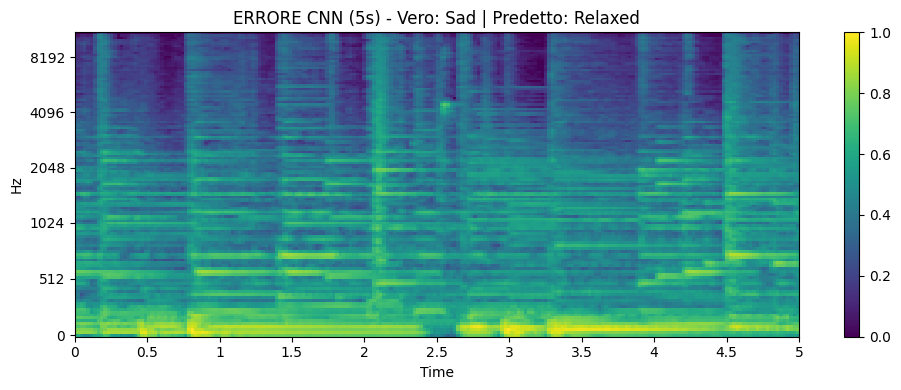

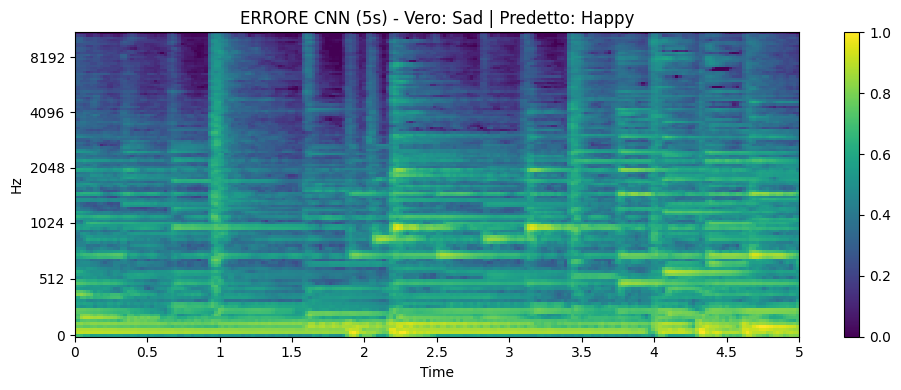

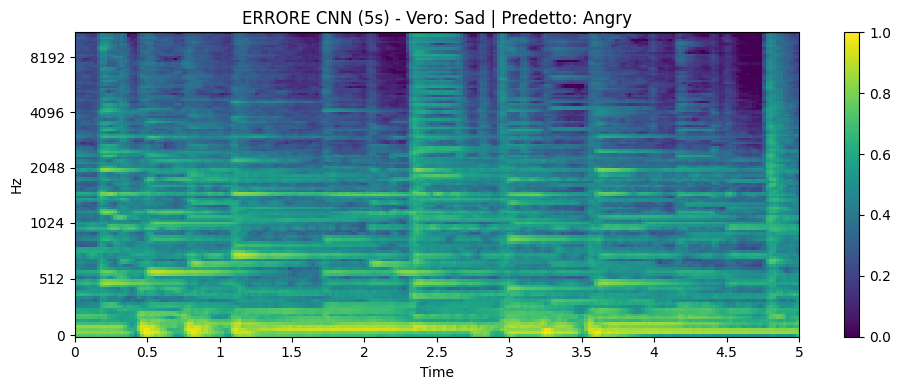

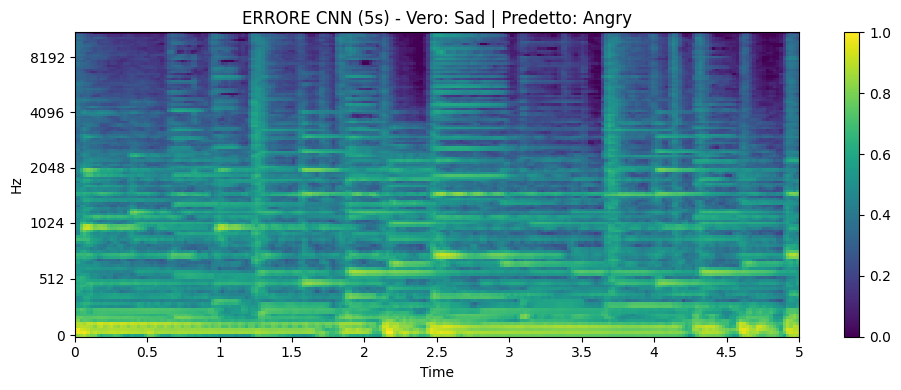

In [ ]:
# Troviamo gli indici degli errori
error_indices = np.where(y_true != y_pred)[0]

for idx in error_indices[:5]:
    mel_spec = X_test[idx][:, :, 0]

    true_label = label_encoder.inverse_transform([y_true[idx]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[idx]])[0]

    plt.figure(figsize=(10, 4))

    # Visualizzazione
    img = librosa.display.specshow(
        mel_spec,
        x_axis='time',
        y_axis='mel',
        sr=22050,
        hop_length=512,
        cmap='viridis'
    )

    # Forza il limite dell'asse X a 5 secondi
    plt.xlim([0, 5])

    plt.colorbar(img)
    plt.title(f"ERRORE CNN (5s) - Vero: {true_label} | Predetto: {pred_label}")
    plt.tight_layout()
    plt.show()